In [1]:
#Import the libraries we will need.
# -*- coding:utf-8 -*-
import tensorflow as tf
import numpy as np
from tensorflow.contrib import rnn
from tensorflow.examples.tutorials.mnist import input_data

%matplotlib inline

In [26]:
# 设置 GPU 按需增长
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

# 首先导入数据，看一下数据的形式
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
print mnist.train.images.shape

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
(55000, 784)


### 首先设置好模型用到的各个超参数

In [131]:
#
lr = 1e-3
# 在训练和测试的时候，我们想用不同的 batch_size.所以采用占位符的方式
#batch_size = tf.placeholder(tf.int32)  # 注意类型必须为 tf.int32
# 在 1.0 版本以后请使用 ：
keep_prob = tf.placeholder(tf.float32, [])
batch_size = tf.placeholder(tf.int32, [])

# 每个时刻的输入特征是28维的，就是每个时刻输入一行，一行有 28 个像素
input_size = 28
# 时序持续长度为28，即每做一次预测，需要先输入28行
timestep_size = 28
# 每个隐含层的节点数
hidden_size = 28*28
# LSTM layer 的层数
layer_num = 2
# 最后输出分类类别数量，如果是回归预测的话应该是 1
class_num = 10

_X = tf.placeholder(tf.float32, [None, 784])
y = tf.placeholder(tf.float32, [None, class_num])
keep_prob = tf.placeholder(tf.float32)


### 开始搭建 RNN 模型

In [132]:
# 把784个点的字符信息还原成 28 * 28 的图片
# 下面几个步骤是实现 RNN / LSTM 的关键
####################################################################
# **步骤1：RNN 的输入shape = (batch_size, timestep_size, input_size) 
timestep_size=28/28
input_size=28*28
X = tf.reshape(_X, [-1, timestep_size, input_size])

#output = new_state = act(W input + U state + B)
Rnn_W = tf.Variable(tf.truncated_normal([input_size,hidden_size], stddev=0.1), dtype=tf.float32)
Rnn_U = tf.Variable(tf.truncated_normal([hidden_size,hidden_size], stddev=0.1), dtype=tf.float32)
Rnn_bias = tf.Variable(tf.constant(0.1,shape=[hidden_size]), dtype=tf.float32)

outputs = list()
new_state = tf.matmul(X[:,0,0:1],tf.Variable(tf.constant(0.1,shape=[1,hidden_size]), dtype=tf.float32))

#超级无语，竟然batch_size不能作为Variable的入参
#print(new_state)

for timestep in range(layer_num):
    new_state = tf.nn.tanh(tf.matmul(X[:, 0, :], Rnn_W)+ tf.matmul(new_state, Rnn_U)+ Rnn_bias)
    outputs.append(new_state)
h_state = outputs[-1]


### 设置 loss function 和 优化器

In [133]:
# 上面 LSTM 部分的输出会是一个 [hidden_size] 的tensor，我们要分类的话，还需要接一个 softmax 层
# 首先定义 softmax 的连接权重矩阵和偏置
out_W = tf.placeholder(tf.float32, [hidden_size, class_num], name='out_Weights')
out_bias = tf.placeholder(tf.float32, [class_num], name='out_bias')
# 开始训练和测试
W = tf.Variable(tf.truncated_normal([hidden_size, class_num], stddev=0.1), dtype=tf.float32)
bias = tf.Variable(tf.constant(0.1,shape=[class_num]), dtype=tf.float32)
y_pre = tf.nn.softmax(tf.matmul(h_state, W) + bias)

# 损失和评估函数
cross_entropy = -tf.reduce_mean(y * tf.log(y_pre))
train_op = tf.train.AdamOptimizer(lr).minimize(cross_entropy)
#train_op = tf.train.GradientDescentOptimizer(1e-3).minimize(cross_entropy)

correct_prediction = tf.equal(tf.argmax(y_pre,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

In [134]:
sess.run(tf.global_variables_initializer())
for i in range(2000):
    _batch_size = 128
    batch = mnist.train.next_batch(_batch_size)
    if (i+1)%200 == 0:
        train_accuracy = sess.run(accuracy, feed_dict={
            _X:batch[0], y: batch[1], keep_prob: 1.0, batch_size: _batch_size})
        # 已经迭代完成的 epoch 数: mnist.train.epochs_completed
        print "Iter%d, step %d, training accuracy %g" % ( mnist.train.epochs_completed, (i+1), train_accuracy)
    sess.run(train_op, feed_dict={_X: batch[0], y: batch[1], keep_prob: 0.5, batch_size: _batch_size})

# 计算测试数据的准确率
print "test accuracy %g"% sess.run(accuracy, feed_dict={
    _X: mnist.test.images, y: mnist.test.labels, keep_prob: 1.0, batch_size:mnist.test.images.shape[0]})

Iter65, step 200, training accuracy 0.914062
Iter66, step 400, training accuracy 0.96875
Iter66, step 600, training accuracy 0.96875
Iter67, step 800, training accuracy 1
Iter67, step 1000, training accuracy 0.984375
Iter67, step 1200, training accuracy 1
Iter68, step 1400, training accuracy 0.992188
Iter68, step 1600, training accuracy 0.992188
Iter69, step 1800, training accuracy 1
Iter69, step 2000, training accuracy 0.984375
test accuracy 0.9763


In [135]:
#%prun sess.run(train_op, feed_dict={_X: batch[0], y: batch[1], keep_prob: 0.5, batch_size: _batch_size})

### 可视化看看 LSTM 的是怎么做分类的

In [136]:
import matplotlib.pyplot as plt
print mnist.test.labels[6]

[ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]


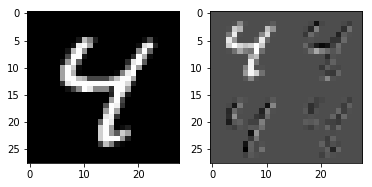

In [137]:
X3 = mnist.test.images[6]
img3 = X3.reshape([28, 28])
plt.subplot(1,2,1)
plt.imshow(img3, cmap='gray')

import pywt,cv2
cA2, (cH2, cV2, cD2)=pywt.wavedec2(np.float32(img3)/255,'haar',level=1);
X2=np.vstack((np.hstack((cA2, cH2)),np.hstack((cV2, cD2))))
plt.subplot(1,2,2)
plt.imshow(X2,cmap='gray')

In [138]:
X3.shape = [-1, 784]
y_batch = mnist.train.labels[0]
y_batch.shape = [-1, class_num]

X3_outputs = np.array(sess.run(outputs, feed_dict={
            _X: X3, y: y_batch, keep_prob: 1.0, batch_size: 1}))
print X3_outputs.shape
X3_outputs.shape = [-1,28, 28]
print X3_outputs.shape


(2, 1, 784)
(2, 28, 28)


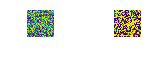

In [139]:
h_W = sess.run(W, feed_dict={
            _X:X3, y: y_batch, keep_prob: 1.0, batch_size: 1})
h_bias = sess.run(bias, feed_dict={
            _X:X3, y: y_batch, keep_prob: 1.0, batch_size: 1})
h_bias.shape = [-1, 10]

bar_index = range(class_num)
for i in xrange(X3_outputs.shape[0]):
    plt.subplot(7, 4, i+1)
    plt.imshow(X3_outputs[i,:,:])
    plt.axis('off')
plt.show()
